# EfficientNet

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
LABELS_CSV_PATH = '/kaggle/input/preprocess-result-fc23/labels.csv'
NEW_BASE_PATH = "/kaggle/input/preprocess-result-fc23/"
IMG_SIZE = 224 
BATCH_SIZE = 32 
LEARNING_RATE = 1e-4 
EPOCHS = 10 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
try:
    labels_df = pd.read_csv(LABELS_CSV_PATH)
    labels_df['filepath'] = labels_df['filepath'].apply(lambda x: os.path.join(NEW_BASE_PATH, os.path.basename(x)))
    print(f"Successfully loaded labels.csv. Number of entries: {len(labels_df)}")
except FileNotFoundError:
    print(f"Error: {LABELS_CSV_PATH} not found. Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading or processing labels_df: {e}")
    exit()

try:
    if labels_df['label'].dtype != 'int':
        labels_df['label'] = labels_df['label'].astype(int)
    NUM_CLASSES = labels_df['label'].nunique()
    if NUM_CLASSES == 0:
        raise ValueError("No unique classes found in 'label' column.")
    print(f"Number of unique classes: {NUM_CLASSES}")
except Exception as e:
    print(f"Error determining number of classes or processing 'label' column: {e}")
    print("Please ensure your 'label' column in labels.csv contains integer class indices (e.g., 0, 1, 2...).")
    exit()

Successfully loaded labels.csv. Number of entries: 6974
Number of unique classes: 2


In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        label = int(self.dataframe.iloc[idx]['label'])

        if not os.path.exists(img_path):
            print(f"Warning: File not found (idx {idx}): {img_path}. Returning None.")
            return None, None

        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image (idx {idx}) {img_path} (cv2.imread failed). Skipping.")
                return None, None
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image (idx {idx}) {img_path} with cv2: {e}")
            return None, None

        if self.transform:
            try:
                image = self.transform(image) 
            except Exception as e:
                print(f"Error applying transform to image (idx {idx}) {img_path}: {e}")
                return None, None
        
        if image is None: 
             print(f"Warning: Image became None unexpectedly before tensor conversion (idx {idx}) {img_path}. Skipping.")
             return None, None

        return image, torch.tensor(label, dtype=torch.long)

In [5]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=0.1,
        fill=0
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=preprocess.mean,
        std=preprocess.std
    )
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=preprocess.mean, std=preprocess.std)
])

In [6]:
valid_indices = [i for i, row in labels_df.iterrows() if os.path.exists(row['filepath'])]
if len(valid_indices) < len(labels_df):
    print(f"Warning: {len(labels_df) - len(valid_indices)} image paths were invalid and removed.")
    labels_df_filtered = labels_df.iloc[valid_indices].reset_index(drop=True)
else:
    labels_df_filtered = labels_df

if len(labels_df_filtered) == 0:
    print("No valid image paths found after filtering. Exiting.")
    exit()

stratify_column = labels_df_filtered['label']

if NUM_CLASSES <= 1: # Stratification requires at least 2 classes
    train_df, test_df = train_test_split(labels_df_filtered, test_size=0.2, random_state=42)
    print("Warning: Number of classes is 1 or less, stratification is disabled.")
else:
    try:
        train_df, test_df = train_test_split(labels_df_filtered, test_size=0.2, random_state=42, stratify=stratify_column)
    except ValueError as e:
        print(f"Error during train_test_split stratification: {e}")
        print("This can happen if a class has too few samples. Falling back to non-stratified split.")
        train_df, test_df = train_test_split(labels_df_filtered, test_size=0.2, random_state=42)


print(f"Training samples: {len(train_df)}, Test samples: {len(test_df)}")

Training samples: 5579, Test samples: 1395


In [7]:
def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch: 
        return torch.Tensor(), torch.Tensor() 
    return torch.utils.data.dataloader.default_collate(batch)

train_dataset = CustomImageDataset(train_df, transform=train_transforms)
test_dataset = CustomImageDataset(test_df, transform=test_transforms)

def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x[0] is not None and x[1] is not None, batch))
    if not batch:
        return torch.Tensor(), torch.Tensor()
    return torch.utils.data.dataloader.default_collate(batch)

train_dataset = CustomImageDataset(train_df, transform=train_transforms)
test_dataset = CustomImageDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn_skip_none)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn_skip_none)

In [8]:
model = efficientnet_b0(weights=weights) 

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(num_ftrs, NUM_CLASSES)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 87.6MB/s]


In [9]:
print(f"Starting training on {DEVICE} for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")

    for inputs, labels in progress_bar_train:
        if inputs.nelement() == 0: # Skip if batch is empty (all images failed)
            continue
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        progress_bar_train.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_train if total_train > 0 else 0
    epoch_acc = (correct_train / total_train) * 100 if total_train > 0 else 0
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []

    progress_bar_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch")
    with torch.no_grad():
        for inputs, labels in progress_bar_val:
            if inputs.nelement() == 0: 
                continue
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            progress_bar_val.set_postfix(loss=loss.item())

    val_loss = running_val_loss / total_val if total_val > 0 else 0
    val_acc = (correct_val / total_val) * 100 if total_val > 0 else 0
    print(f"Epoch {epoch+1}/{EPOCHS} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
print("Training finished.")

Starting training on cuda for 10 epochs...


Epoch 1/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 1/10 - Train Loss: 0.4076, Train Acc: 84.62%


Epoch 1/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 1/10 - Val Loss: 0.3834, Val Acc: 85.81%


Epoch 2/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 2/10 - Train Loss: 0.3295, Train Acc: 87.04%


Epoch 2/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 2/10 - Val Loss: 0.3645, Val Acc: 86.52%


Epoch 3/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 3/10 - Train Loss: 0.2883, Train Acc: 88.58%


Epoch 3/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 3/10 - Val Loss: 0.3105, Val Acc: 88.82%


Epoch 4/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 4/10 - Train Loss: 0.2525, Train Acc: 89.23%


Epoch 4/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 4/10 - Val Loss: 0.3307, Val Acc: 88.67%


Epoch 5/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 5/10 - Train Loss: 0.2281, Train Acc: 90.28%


Epoch 5/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 5/10 - Val Loss: 0.3259, Val Acc: 88.39%


Epoch 6/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 6/10 - Train Loss: 0.1991, Train Acc: 91.95%


Epoch 6/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 6/10 - Val Loss: 0.2822, Val Acc: 89.25%


Epoch 7/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 7/10 - Train Loss: 0.1756, Train Acc: 92.70%


Epoch 7/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 7/10 - Val Loss: 0.2968, Val Acc: 89.10%


Epoch 8/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 8/10 - Train Loss: 0.1584, Train Acc: 93.57%


Epoch 8/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 8/10 - Val Loss: 0.2996, Val Acc: 89.39%


Epoch 9/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 9/10 - Train Loss: 0.1483, Train Acc: 93.96%


Epoch 9/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 9/10 - Val Loss: 0.3224, Val Acc: 89.18%


Epoch 10/10 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 10/10 - Train Loss: 0.1407, Train Acc: 94.08%


Epoch 10/10 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 10/10 - Val Loss: 0.3339, Val Acc: 89.53%
Training finished.



Starting Final Testing Phase...


Final Testing:   0%|          | 0/44 [00:00<?, ?batch/s]

Final Test Loss: 0.3339
Final Test Accuracy: 89.53%

Generating Confusion Matrix from Final Test Results...


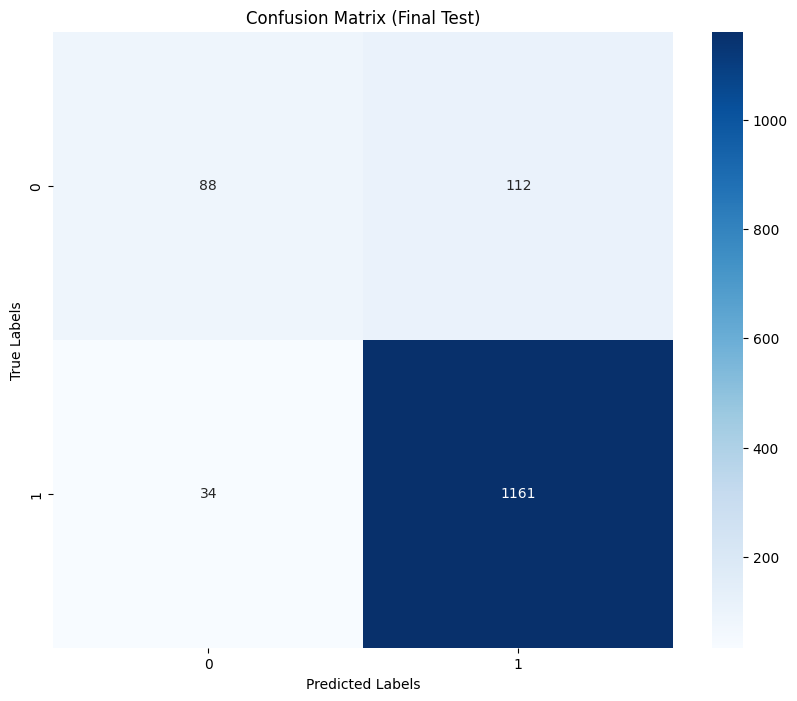

Model saved to efficientnet_b0_custom_pytorch.pth


In [10]:
print("\nStarting Final Testing Phase...")
model.eval()  

final_test_loss = 0.0
final_correct_test = 0
final_total_test = 0
final_all_preds = []
final_all_labels = []

with torch.no_grad(): 
    for inputs, labels in tqdm(test_loader, desc="Final Testing", unit="batch"): 
        if inputs.nelement() == 0: 
            continue
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels) 

        final_test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        final_total_test += labels.size(0)
        final_correct_test += (predicted == labels).sum().item()

        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_total_test > 0:
    avg_final_test_loss = final_test_loss / final_total_test
    final_test_accuracy = (final_correct_test / final_total_test) * 100
    print(f"Final Test Loss: {avg_final_test_loss:.4f}")
    print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")
else:
    print("No data was processed in the test loader during final testing.")

if final_total_test > 0:
    print("\nGenerating Confusion Matrix from Final Test Results...")
    cm = confusion_matrix(final_all_labels, final_all_preds) 
    plt.figure(figsize=(10, 8))
    class_names = [str(i) for i in range(NUM_CLASSES)] 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Final Test)')
    plt.show()
else:
    print("No data was processed in the test loader, cannot generate confusion matrix.")

torch.save(model.state_dict(), 'efficientnet_b0_custom_pytorch.pth')
print("Model saved to efficientnet_b0_custom_pytorch.pth")